**Here we transform the cleaned point-by-point data into structured observation arrays for Bayesian inference.**

Objectives

1.  **Filter**: Isolate the target match (Sinner vs. Medvedev, 2024).
2.  **Observation Encoding**: Convert raw game states into binary sequences suitable for PyMC likelihoods:
      * **Serve Outcome**: Did the first serve go in? ($y \in \{0, 1\}$)
      * **Ace Outcome**: Was the serve an ace? ($y \in \{0, 1\}$)
      * **Server ID**: Index of who is serving ($idx \in \{0, 1\}$)
3.  **Momentum Features**: Calculate rolling averages to visualize the "ground truth" dynamics before modeling.
4.  **Visualization**: Plot these running statistics against point outcomes to inspect correlations before modeling.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent 
DATA_DIR = PROJECT_ROOT / "data" / "raw"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
SRC_DIR = PROJECT_ROOT / "notebooks_src"

#  Constants
TARGET_MATCH_ID = '2024-wimbledon-1501'
PLAYER_1_NAME = 'Jannik Sinner'
PLAYER_2_NAME = 'Daniil Medvedev'


In [25]:
points_2024 = pd.read_csv(PROCESSED_DIR / '2024-wimbledon-points-corrected.csv')
matches_2024 = pd.read_csv(DATA_DIR / '2024-wimbledon-matches.csv')

# Load 2023 Priors
with open(PROCESSED_DIR / 'priors_2023.pkl', 'rb') as f:
    priors = pickle.load(f)

# Filter for Target Match
match_mask = points_2024['match_id'] == TARGET_MATCH_ID
target_match = points_2024[match_mask].copy().reset_index(drop=True)

if target_match.empty:
    raise ValueError(f"Match {TARGET_MATCH_ID} not found in dataset.")

# Identify Players
match_meta = matches_2024[matches_2024['match_id'] == TARGET_MATCH_ID].iloc[0]
p1_name = match_meta['player1']
p2_name = match_meta['player2']

print(f"Target Match Loaded: {len(target_match)} points")
print(f"P1: {p1_name}")
print(f"P2: {p2_name}")

# Extract Historical Means for Baselines
p1_key = p1_name.lower().replace(' ', '_')
p2_key = p2_name.lower().replace(' ', '_')

hist_srv_pct = {
    1: priors[p1_key]['serve_pct']['mean'],
    2: priors[p2_key]['serve_pct']['mean']
}

hist_ace_rate = {
    1: priors[p1_key]['ace_rate']['mean'],
    2: priors[p2_key]['ace_rate']['mean']
}

print("\nHistorical Baselines (2023):")
print(f"P1 ({p1_name}) Serve %: {hist_srv_pct[1]:.3f}")
print(f"P2 ({p2_name}) Serve %: {hist_srv_pct[2]:.3f}")

Target Match Loaded: 326 points
P1: Jannik Sinner
P2: Daniil Medvedev

Historical Baselines (2023):
P1 (Jannik Sinner) Serve %: 0.578
P2 (Daniil Medvedev) Serve %: 0.695


## Engineering Bayesian Observations

We calculate running statistics for every point.
To handle the high variance at the start of the match (small sample size), we apply 

Bayesian Smoothing:$$\text{Smoothed Stat} = w \cdot \text{Observed} + (1-w) \cdot \text{Historical}$$Where $w = \frac{n}{10}$ for the first 10 serves, and $w=1$ thereafter.

In [26]:
def calculate_running_stats(match_df, hist_srv, hist_ace, smoothing_window=10):
    """
    Calculate running serve statistics with Bayesian smoothing for early points.
    
    Returns a DataFrame containing:
    - srv_pct: Smoothed running first serve percentage
    - ace_rate: Smoothed running ace rate
    - y: Point outcome (1 if server won, 0 if server lost)
    """
    # Trackers for P1 (index 1) and P2 (index 2)
    stats = {
        1: {'in': 0, 'attempts': 0, 'aces': 0, 'serves': 0},
        2: {'in': 0, 'attempts': 0, 'aces': 0, 'serves': 0}
    }
    
    features = []
    
    for idx, row in match_df.iterrows():
        server = row['PointServer']
        
        # Calculate deltas (current - previous) to determine what happened on this specific point
        if idx == 0:
            p1_in_prev, p2_in_prev = 0, 0
            p1_ace_prev, p2_ace_prev = 0, 0
        else:
            prev = match_df.iloc[idx - 1]
            p1_in_prev = prev['P1FirstSrvIn']
            p2_in_prev = prev['P2FirstSrvIn']
            p1_ace_prev = prev['P1Ace']
            p2_ace_prev = prev['P2Ace']
            
        # Get outcomes for this point
        # Note: We rely on the cumulative columns corrected in Notebook 1
        d_p1_in = row['P1FirstSrvIn'] - p1_in_prev
        d_p2_in = row['P2FirstSrvIn'] - p2_in_prev
        d_p1_ace = row['P1Ace'] - p1_ace_prev
        d_p2_ace = row['P2Ace'] - p2_ace_prev
        
        # Update active server stats
        if server == 1:
            stats[1]['serves'] += 1
            stats[1]['attempts'] += 1
            stats[1]['in'] += d_p1_in
            stats[1]['aces'] += d_p1_ace
            current_stats = stats[1]
            hist_base_srv = hist_srv[1]
            hist_base_ace = hist_ace[1]
            server_idx = 0 # 0 for P1
        else:
            stats[2]['serves'] += 1
            stats[2]['attempts'] += 1
            stats[2]['in'] += d_p2_in
            stats[2]['aces'] += d_p2_ace
            current_stats = stats[2]
            hist_base_srv = hist_srv[2]
            hist_base_ace = hist_ace[2]
            server_idx = 1 # 1 for P2
            
        # Raw Calculation
        n = current_stats['serves']
        raw_srv = current_stats['in'] / current_stats['attempts'] if current_stats['attempts'] > 0 else 0
        raw_ace = current_stats['aces'] / n if n > 0 else 0
        
        # Bayesian Smoothing
        if n < smoothing_window:
            w = n / smoothing_window
            srv_pct = (w * raw_srv) + ((1 - w) * hist_base_srv)
            ace_rate = (w * raw_ace) + ((1 - w) * hist_base_ace)
        else:
            srv_pct = raw_srv
            ace_rate = raw_ace
            
        # Outcome: 1 if server won, 0 if lost
        y = 1 if row['PointWinner'] == server else 0
        
        features.append({
            'point_number': row['PointNumber'],
            'server_id': server_idx,
            'srv_pct': srv_pct,
            'ace_rate': ace_rate,
            'hist_srv_pct': hist_base_srv,
            'hist_ace_rate': hist_base_ace,
            'y': y
        })
        
    return pd.DataFrame(features)

print("Calculating running statistics...")
features_df = calculate_running_stats(target_match, hist_srv_pct, hist_ace_rate)

# We calculate Z-scores (mean 0, std 1) to solve the scaling issue in PyMC.
# This makes the coefficients (betas) comparable and easier to sample.
features_df['srv_pct_scaled'] = (features_df['srv_pct'] - features_df['srv_pct'].mean()) / features_df['srv_pct'].std()
features_df['ace_rate_scaled'] = (features_df['ace_rate'] - features_df['ace_rate'].mean()) / features_df['ace_rate'].std()

print(f"Features generated: {len(features_df)} rows")
print(features_df[['server_id', 'srv_pct', 'srv_pct_scaled', 'y']].head())

Calculating running statistics...
Features generated: 326 rows
   server_id   srv_pct  srv_pct_scaled  y
0          1  0.625179       -0.234735  1
1          1  0.555714       -1.526018  1
2          1  0.586250       -0.958384  0
3          1  0.516786       -2.249667  0
4          1  0.547321       -1.682034  1


## 3\. Momentum Visualization (Rolling Averages)

We visualize the engineered features to verify that the smoothing is working (no sharp jumps at the start) and to explore potential correlations between serve performance and point outcomes.

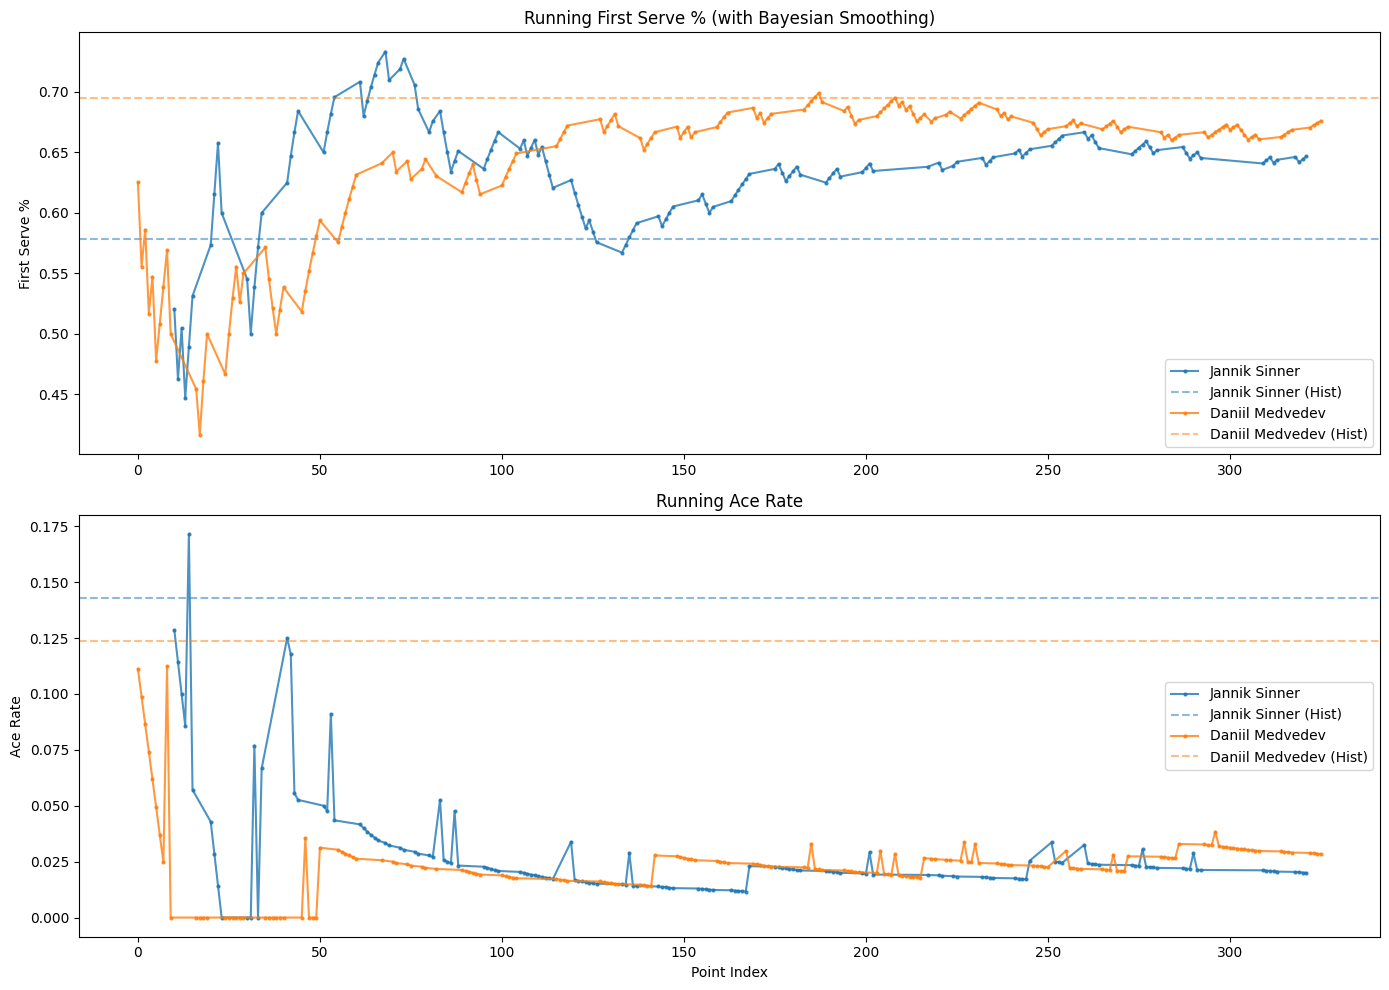

In [27]:
# Plot 1: Running Statistics over Time
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

p1_data = features_df[features_df['server_id'] == 0]
p2_data = features_df[features_df['server_id'] == 1]

# Subplot 1: First Serve %
ax = axes[0]
# Plot P1 
ax.plot(p1_data.index, p1_data['srv_pct'], label=f"{p1_name}", 
        color='tab:blue', linewidth=1.5, marker='.', markersize=4, alpha=0.8)
ax.axhline(hist_srv_pct[1], color='tab:blue', linestyle='--', alpha=0.5, label=f"{p1_name} (Hist)")

# Plot P2 
ax.plot(p2_data.index, p2_data['srv_pct'], label=f"{p2_name}", 
        color='tab:orange', linewidth=1.5, marker='.', markersize=4, alpha=0.8)
ax.axhline(hist_srv_pct[2], color='tab:orange', linestyle='--', alpha=0.5, label=f"{p2_name} (Hist)")

ax.set_title("Running First Serve % (with Bayesian Smoothing)")
ax.set_ylabel("First Serve %")
ax.legend()

# Subplot 2: Ace Rate
ax = axes[1]
# Plot P1 
ax.plot(p1_data.index, p1_data['ace_rate'], label=f"{p1_name}", 
        color='tab:blue', linewidth=1.5, marker='.', markersize=4, alpha=0.8)
ax.axhline(hist_ace_rate[1], color='tab:blue', linestyle='--', alpha=0.5, label=f"{p1_name} (Hist)")

# Plot P2 
ax.plot(p2_data.index, p2_data['ace_rate'], label=f"{p2_name}", 
        color='tab:orange', linewidth=1.5, marker='.', markersize=4, alpha=0.8)
ax.axhline(hist_ace_rate[2], color='tab:orange', linestyle='--', alpha=0.5, label=f"{p2_name} (Hist)")

ax.set_title("Running Ace Rate")
ax.set_ylabel("Ace Rate")
ax.set_xlabel("Point Index")
ax.legend()

plt.tight_layout()
plt.show()

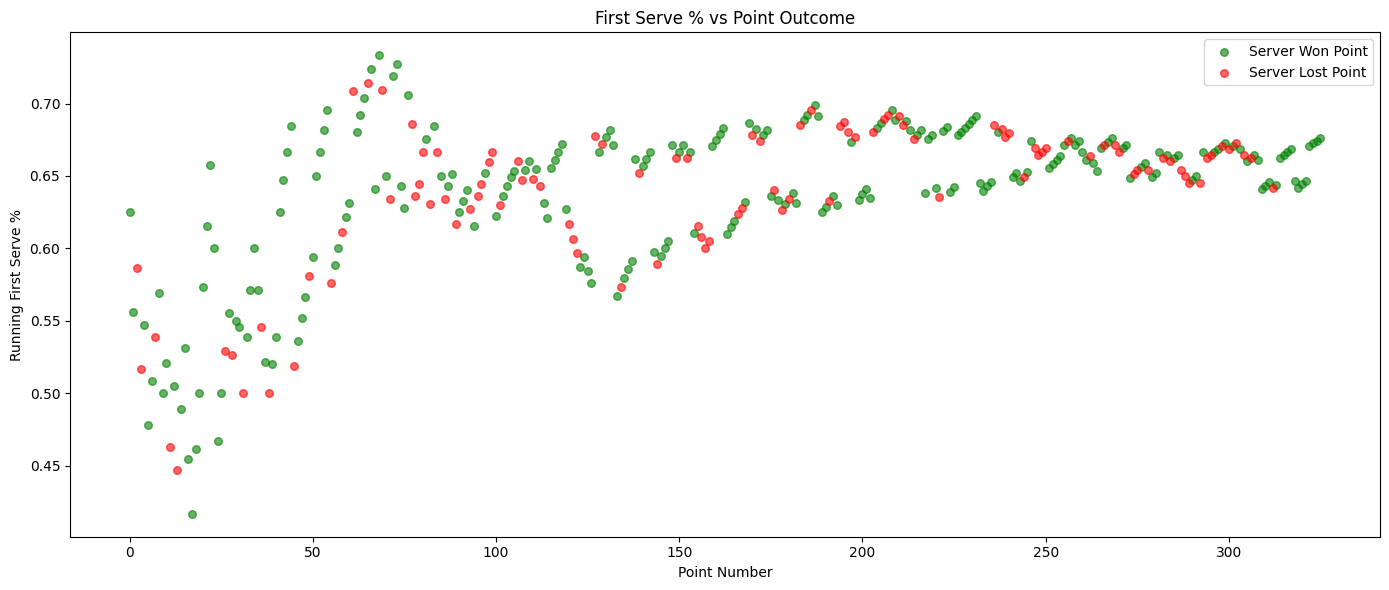

In [28]:
# Plot 2: Scatter Plot of Outcomes vs Serve %
fig, ax = plt.subplots(figsize=(14, 6))

won = features_df[features_df['y'] == 1]
lost = features_df[features_df['y'] == 0]

ax.scatter(won.index, won['srv_pct'], c='green', label='Server Won Point', alpha=0.6, s=30)
ax.scatter(lost.index, lost['srv_pct'], c='red', label='Server Lost Point', alpha=0.6, s=30)

ax.set_title('First Serve % vs Point Outcome')
ax.set_xlabel('Point Number')
ax.set_ylabel('Running First Serve %')
ax.legend()

plt.tight_layout()
plt.show()

## Feature Storage

We save the engineered features into a structured dictionary (`.pkl`) for next ipynb.

### Data Structure for PyMC

 - server_id: Index of who is serving (0 = P1, 1 = P2).
 
 - srv_pct: Smoothed running first serve percentage (Predictor $X_1$).
 
 - ace_rate: Smoothed running ace rate (Predictor $X_2$).
 
 - hist_srv_pct: Historical baseline for calculation of deviation.
 
 - y: Point outcome (1 = Server Won, 0 = Server Lost) (Observed $y$).

In [29]:
# Range Check
in_range = (features_df['srv_pct'].between(0, 1).all()) and (features_df['ace_rate'].between(0, 1).all())
print(f"Features within [0, 1] range: {in_range}")

# Scale Check (Ensure no z-scoring)
mean_srv = features_df['srv_pct'].mean()
print(f"Global Mean First Serve %: {mean_srv:.3f}")

# Save to Pickle 
output_path = PROCESSED_DIR / 'features_match_1501.pkl'
features_df.to_pickle(output_path)

Features within [0, 1] range: True
Global Mean First Serve %: 0.638
